In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [90]:
df=pd.read_csv('bikes.csv')
print(df.shape)

(1488, 13)


In [10]:
df.head()

,hr,holiday,workingday,temp,hum,windspeed,cnt,instant,mnth,yr,Clear to partly cloudy,Light Precipitation,Misty
0,0,0,0,0.76,0.66,0.0000,149,13004,7,1,1,0,0
1,1,0,0,0.74,0.70,0.1343,93,13005,7,1,1,0,0
2,2,0,0,0.72,0.74,0.0896,90,13006,7,1,1,0,0
3,3,0,0,0.72,0.84,0.1343,33,13007,7,1,1,0,0
4,4,0,0,0.70,0.79,0.1940,4,13008,7,1,1,0,0


In [14]:
X=df.drop('cnt',axis=1)
y=df['cnt']

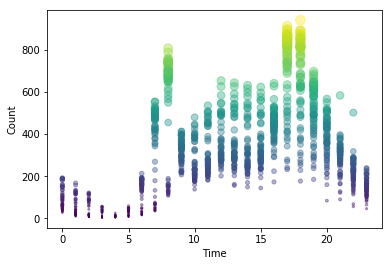

In [44]:
plt.scatter(X['hr'],y,alpha=0.4,s=y/10,c=y)
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [99]:
for deep in range(1,10,2):
    dt=DecisionTreeRegressor(max_depth=deep,min_samples_leaf=10,random_state=42)
    dt.fit(X_train,y_train)
    train_rmse=MSE(y_train,dt.predict(X_train))**(1/2)
    rmse_dt=MSE(y_test,dt.predict(X_test))**(1/2)
    print("Depth=",deep," Train RMSE=",train_rmse," Test RMSE=",rmse_dt)

Depth= 1  Train RMSE= 160.66751027567844  Test RMSE= 171.80923353790143
Depth= 3  Train RMSE= 130.31224296401  Test RMSE= 137.66573122559217
Depth= 5  Train RMSE= 85.68866992179723  Test RMSE= 101.93073993373562
Depth= 7  Train RMSE= 53.10332671642508  Test RMSE= 70.21064037074012
Depth= 9  Train RMSE= 48.73792817439718  Test RMSE= 65.8549754715434


Seems like a tree depth of 6 or 7 is the right depth? We do a Grid Search to verify..

In [88]:
param_grid={'max_depth':np.arange(1,21),'min_samples_leaf':np.arange(5,30)}
dt=DecisionTreeRegressor(random_state=42)
dt_cv=GridSearchCV(dt,param_grid,cv=10,scoring='neg_mean_squared_error')
dt_cv.fit(X_train,y_train)
print(dt_cv.best_params_,(-dt_cv.best_score_)**(1/2))

{'max_depth': 11, 'min_samples_leaf': 7} 59.132311123234246


Hmm.. so perhaps a depth of 11 is a better choice? Let's see if that indeed is true

In [122]:
dt=DecisionTreeRegressor(max_depth=11,min_samples_leaf=7,random_state=42)
dt.fit(X_train,y_train)
print(MSE(y_test,dt.predict(X_test))**(1/2))
print("CV RMSE=",(np.average(-cross_val_score(dt,X_train,y_train,cv=5,scoring='neg_mean_squared_error')))**(1/2))

63.438328716321806
CV RMSE= 63.31901119332694


In [123]:
bc=BaggingRegressor(base_estimator=dt,n_estimators=200,oob_score=True)
bc.fit(X_train,y_train)
print("OOB score=",bc.oob_score_,"Test RMSE=",MSE(y_test,bc.predict(X_test))**(1/2))
print("CV RMSE=",(np.average(-cross_val_score(bc,X_train,y_train,cv=5,scoring='neg_mean_squared_error')))**(1/2))

OOB score= 0.9359230118742601 Test RMSE= 62.318031266700466
CV RMSE= 60.044016819083794


In [124]:
rf=RandomForestRegressor(n_estimators=200,min_samples_leaf=7,oob_score=True)
rf.fit(X_train,y_train)
print("OOB score=",rf.oob_score_,"Test RMSE=",MSE(y_test,rf.predict(X_test))**(1/2))
print("CV RMSE=",(np.average(-cross_val_score(rf,X_train,y_train,cv=5,scoring='neg_mean_squared_error')))**(1/2))

OOB score= 0.9346820700268892 Test RMSE= 62.9179221697311
CV RMSE= 60.27805100061877


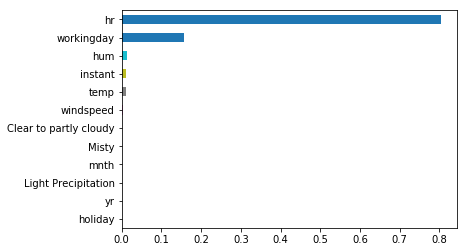

In [128]:
importances_rf=pd.Series(rf.feature_importances_,index=X.columns)
sort_importances_rf=importances_rf.sort_values()
sort_importances_rf.plot(kind='barh')
plt.show()


Not unexpectedly, time of the day and whether it's a holiday determine bike rentals the most.